In [1]:
# Imports

# Usual imports
import os
import sys
import time
import datetime
import json
import csv
import glob
import pprint
import importlib
from tqdm import tqdm
from collections import Counter

import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

import itertools
import time
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('seaborn-talk')

from matplotlib import rc
rc('font',**{'family':'serif','serif':['FreeSerif']})
rc('text', usetex=False)
from matplotlib import rc
sns.set_palette("Set2")

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm, style
from matplotlib.ticker import FixedLocator
from matplotlib.dates import DateFormatter

import seaborn as sns
from IPython.display import Image
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter

# For regression
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

# Custom modules
sys.path.insert(0, '../')
import psychometry
import parser
import utils

# Some edits to matplotlib
# https://towardsdatascience.com/simple-ways-to-improve-your-matplotlib-b64eebccfd5
# https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08
#plt.rcParams.update({'font.size': 20})
style.use('seaborn-talk') #sets the size of the charts

# This is the color of sh.rice.edu/covid-sense website background. It is NOT white
bg_color = (0.96862745, 0.96862745, 0.96862745)

# Convert a timestamp into time string
d2s = lambda x : datetime.datetime.fromtimestamp(x/1000.0).strftime('%B %d')

# Save all files here:
#saveroot = '/home/vishwanath/Dropbox/Apps/Overleaf/CovidSense Analysis/figures/'
saveroot = 'D:/Dropbox/Apps/Overleaf/CovidSense Analysis/figures/'

In [2]:
def hypo(arr1, arr2, arr1_name, arr2_name, alternate='greater'):
    mw_stat, mw_pval = stats.mannwhitneyu(arr1, arr2, alternative=alternate)
    tt_stat, tt_pval = stats.ttest_ind(arr1, arr2, equal_var=False)
    
    print('[%s]: %.2f +/- %.2f'%(arr1_name, arr1.mean(), np.sqrt(arr1.var())))
    print('[%s]: %.2f +/- %.2f'%(arr2_name, arr2.mean(), np.sqrt(arr2.var())))
    
    print('Mann-Whitney U: stat: %.2f; pval: %.6f'%(mw_stat, mw_pval))
    print('t-test: stat: %.2f; pval: %.6f'%(tt_stat, tt_pval))

    return mw_pval, tt_pval


In [3]:
# Load database
dbname = '../data/db_snapshot.json'

with open(dbname, 'rb') as readfile:
    db = json.load(readfile)

lens = np.array([len(db[key]['timestamps']) for key in db])
print(lens.sum())


18783


In [4]:
# Separate into age groups
db18_25 = {key:db[key] for key in db if (db[key]['age'] > 18) and (db[key]['age'] <= 25)}
db25_40 = {key:db[key] for key in db if (db[key]['age'] > 25) and (db[key]['age'] <= 40)}
db40_60 = {key:db[key] for key in db if (db[key]['age'] > 40) and (db[key]['age'] <= 60)}
db60 = {key:db[key] for key in db if (db[key]['age'] > 60)}


In [5]:
ipip_idx = 3
ipip18_25 = np.array([val for val in utils.getall(db18_25, 'ipip') if val != 'not supplied'])[:, ipip_idx]
ipip25_40 = np.array([val for val in utils.getall(db25_40, 'ipip') if val != 'not supplied'])[:, ipip_idx]
ipip40_60 = np.array([val for val in utils.getall(db40_60, 'ipip') if val != 'not supplied'])[:, ipip_idx]
ipip60 = np.array([val for val in utils.getall(db60, 'ipip') if val != 'not supplied'])[:, ipip_idx]

mwp, ttp = hypo(ipip18_25, np.hstack((ipip25_40, ipip40_60, ipip60)), '18 - 25', '25 -', 'less')

print('%e'%mwp)

[18 - 25]: 1.94 +/- 0.55
[25 -]: 2.06 +/- 0.54
Mann-Whitney U: stat: 36987.00; pval: 0.009821
t-test: stat: -2.37; pval: 0.018219
9.821041e-03


In [43]:
utils = importlib.reload(utils)
_, qids18_25 = utils.getqids(db18_25)
_, qids25_40 = utils.getqids(db25_40)
_, qids40_60 = utils.getqids(db40_60)
_, qids60 = utils.getqids(db60)

arr1 = qids18_25
arr2 = np.hstack((qids25_40, qids40_60, qids60))
indices = np.random.permutation(arr2.size)[:arr1.size]
hypo(arr1, arr2[indices], '18 - 25', '25 - ', 'greater')

#arr1_g = arr1.mean() + arr1.std()*np.random.randn(arr1.size)

#hypo(arr1, arr1_g, 'Original', 'Gaussian', 'less')



[18 - 25]: 10.12 +/- 5.98
[25 - ]: 7.91 +/- 5.13
Mann-Whitney U: stat: 37695.50; pval: 0.000007
t-test: stat: 4.42; pval: 0.000012


(6.573854038870553e-06, 1.2260144312961976e-05)

In [35]:
utest = 0

for val1 in arr1:
    for val2 in arr2:
        if val1 > val2:
            utest += 1
        elif val1 == val2:
            utest += 0.5

print(utest)
print(1/(arr1.size*arr2.size))

3467975.0
1.8919646558298714e-07


100%|██████████| 500/500 [06:59<00:00,  1.19it/s]


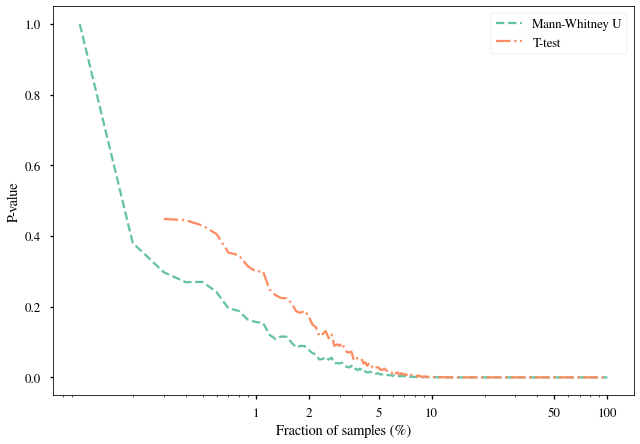

In [24]:
# How accurate is our 'zero p value' measurement?
ntrials = 500
qids25_plus = np.hstack((qids25_40, qids40_60, qids60))
frac_array = np.arange(0.1, 100, 0.1)

mw_p_array = np.zeros(frac_array.size)
tt_p_array = np.zeros(frac_array.size)

for ntrial in tqdm(range(ntrials)):
    for idx, frac in enumerate(frac_array):
        indices18_25 = np.random.permutation(qids18_25.size)[:int(frac*qids18_25.size/100)]
        indices25_plus = np.random.permutation(qids25_plus.size)[:int(frac*qids25_plus.size/100)]

        arr1 = qids18_25[indices18_25]
        arr2 = qids25_plus[indices25_plus]
        _, mw_p_val = stats.mannwhitneyu(arr1, arr2, alternative='greater')
        _, tt_p_val = stats.ttest_ind(arr1, arr2, equal_var=False)

        mw_p_array[idx] += mw_p_val
        tt_p_array[idx] += tt_p_val

mw_p_array /= ntrials
tt_p_array /= ntrials

plt.semilogx(frac_array, mw_p_array, '--', label='Mann-Whitney U')
plt.semilogx(frac_array, tt_p_array, '-.', label='T-test')
plt.xticks([1, 2, 5, 10, 50, 100], labels=['1', '2', '5', '10', '50', '100'])
plt.xlabel('Fraction of samples (%)')
plt.ylabel('P-value')
plt.legend()
plt.savefig('p_value_vs_samples.png')
plt.show()


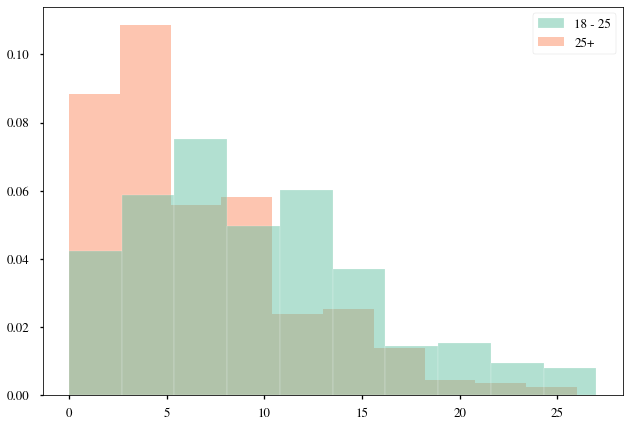

In [38]:
plt.hist(qids18_25, label='18 - 25', alpha=0.5, ec='white', density=True, zorder=2)
plt.hist(qids25_plus, label='25+', alpha=0.5, density=True, zorder=1)
plt.legend()
plt.savefig('hist.png')
plt.show()

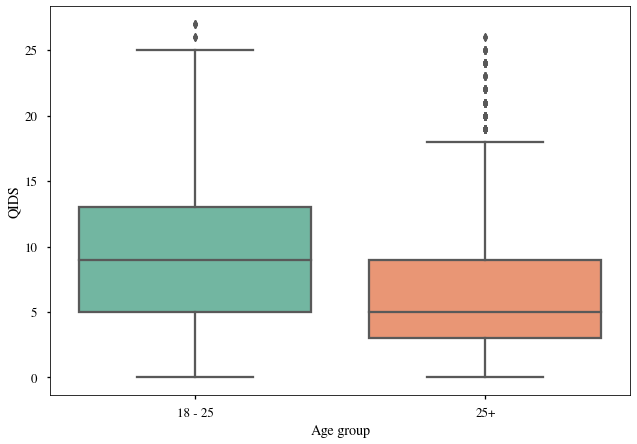

In [48]:
labels1 = ['18 - 25' for _ in arr1]
labels2 = ['25+' for _ in arr2]
len(labels1+labels2)

data_dict = {'QIDS':np.hstack((arr1, arr2)),
             'Age group': labels1+labels2}
data_pd = pd.DataFrame.from_dict(data_dict)

sns.boxplot(x='Age group', y='QIDS', data=data_pd)
plt.savefig('QIDS_boxplot.png')
plt.show()

from scipy import io
io.savemat('data.mat', {'arr1': arr1, 'arr2': arr2})

In [24]:
# Separate based on pre-existing conditions
conversion_dict = {
    'None': ['none of the above', 'None' '(empty)'],
    'Mental health': ['depression', 'anxiety disorder',
               'other serious mental health issues',
               'obsessive compulsive disorder',
               'addiction (drug, alcohol)',
               'bipolar'],
    'Cardio-vascular': ['abnormal blood pressure',
                        'diabetes'],
    'Pulmonary': ['asthma', 'asthma, COPD or other lung disease'],
    'Other health issues': ['cancer', 'other serious health issues'] 
}

db_none = dict()
db_mental = dict()
db_cardio = dict()
db_pulmo = dict()
db_other = dict()

for key in db:
    physical = db[key]['pre_physical']
    mental = db[key]['pre_mental']

    if len(set(conversion_dict['None']).intersection(physical)) > 0 and\
       len(set(conversion_dict['None']).intersection(mental)) > 0:
        db_none[key] = db[key]
    else:            
        if len(set(conversion_dict['Mental health']).intersection(mental)) > 0:
            db_mental[key] = db[key]
        if len(set(conversion_dict['Cardio-vascular']).intersection(physical)) > 0:
            db_cardio[key] = db[key]
        if len(set(conversion_dict['Pulmonary']).intersection(physical)) > 0:
            db_pulmo[key] = db[key]
        if len(set(conversion_dict['Other health issues']).intersection(physical)) > 0:
            db_other[key] = db[key]

537


In [28]:
ipip_idx = 3
ipip_none = np.array([val for val in utils.getall(db_none, 'ipip') if val != 'not supplied'])[:, ipip_idx]
ipip_mental = np.array([val for val in utils.getall(db_mental, 'ipip') if val != 'not supplied'])[:, ipip_idx]
ipip_cardio = np.array([val for val in utils.getall(db_cardio, 'ipip') if val != 'not supplied'])[:, ipip_idx]
ipip_pulmo = np.array([val for val in utils.getall(db_pulmo, 'ipip') if val != 'not supplied'])[:, ipip_idx]
ipip_other = np.array([val for val in utils.getall(db_other, 'ipip') if val != 'not supplied'])[:, ipip_idx]

print('Mental vs. other')
hypo(ipip_mental, np.hstack((ipip_none, ipip_cardio, ipip_pulmo, ipip_other)), 'Mental health', 'Other/none', 'less')

print('\nPulmonary vs. other')
hypo(ipip_pulmo, np.hstack((ipip_none, ipip_cardio, ipip_mental, ipip_other)), 'Pulmonary', 'Other/none', 'less')

print('\n')
print('None vs some')
hypo(ipip_none, np.hstack((ipip_mental, ipip_cardio, ipip_pulmo, ipip_other)), 'None', 'Some', 'greater')

Mental vs. other
[Mental health]: 1.95 +/- 0.57
[Other/none]: 2.03 +/- 0.55
Mann-Whitney U: stat: 77510.50; pval: 0.017807
t-test: stat: -2.11; pval: 0.035628

Pulmonary vs. other
[Pulmonary]: 2.05 +/- 0.58
[Other/none]: 1.99 +/- 0.56
Mann-Whitney U: stat: 35217.00; pval: 0.763872
t-test: stat: 0.91; pval: 0.366033


None vs some
[None]: 2.04 +/- 0.52
[Some]: 1.98 +/- 0.58
Mann-Whitney U: stat: 84000.50; pval: 0.036190
t-test: stat: 1.58; pval: 0.115773
